In this notebook I will have another go at the MNIST data set using Nearest Neighbours, but this time after doing some dimensionality reduction. 

# Starting point
Using a Nearest Neighbours classifier and a training set extended by shifting all digits 1 pixel in every direction I have achieved acieved 97.0% accuracy on the Kaggle MNIST test set. However, I did not have much opportunity to finetune hyperparameters as my laptop did lot enjoy fiding nearest neighbours in the 784 dimensional feature space of MNIST. 

Using PCA to reduce the number of dimensions of the data set I hope to be able to do some more fine tuning using Grid Search.

Previously I have binarized all pixel values. I will start of comparing the results of PCA on raw and binarized features.

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
train_df = pd.read_csv('train.csv')
digits = train_df.iloc[:, 1:].values
labels = train_df['label'].values

# PCA
I will use scikit-learns built in PCA which allows me to choose either a set number of principal components or a specifc level of retained variance. 

In [4]:
from sklearn.decomposition import PCA

## Raw input
Let's start of doing PCA on the raw input (which will still be scaled by sklearn, but not binarized).

In [5]:
# Let's see what the first two principal component looks like.
pca = PCA(n_components=2)
digits_pca = pca.fit_transform(digits)

In [6]:
pca.explained_variance_ratio_

array([ 0.09748938,  0.07160266])

In [7]:
df = pd.DataFrame(digits_pca, columns=('pc1', 'pc2'))
df['label'] = labels

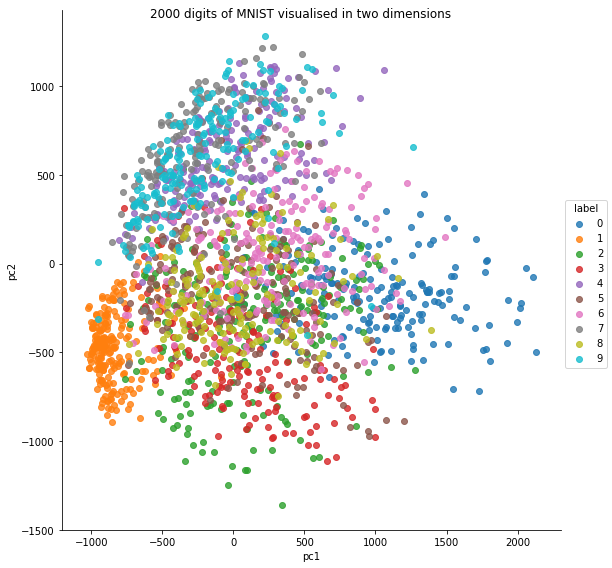

In [8]:
f = sns.lmplot("pc1", "pc2", hue='label', data=df[:2000], fit_reg=False, size=8)
plt.suptitle('2000 digits of MNIST visualised in two dimensions')

Even when projecting our 784 dimensional data down to two dimensions we can still detect quite a bit of clustering. It's interesting to note how digits with similar shapes End up in the same regions. Seven and nine are very much overlapping, two and three are in the same region etc.

When a digit is projected onto the principal component, each pixel of the digits is multiplied by the corresponding value in the principal component's vector, all products are then summarized per principal component. This means each principal component amplifies some pixels and dampens some, and then combine all pixel values in to one feature. Let's have a look at what pixels are amplified by our first two pricipal components.

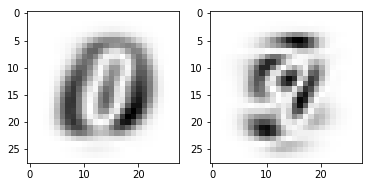

In [9]:
rows, columns = 1, 2
# Let's visualise the absolute values of each feature as a large negative is just as important as a large positive one.
np_abs = np.vectorize(abs)
for i in range(rows*columns):
    plt.subplot(rows, columns, i+1)
    f = plt.imshow(np_abs(pca.components_[i]).reshape(28,28), cmap='Greys')

# Binarized features

What if we binarize the inputs first? WIll we get the sama principal components?

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class DigitBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, cutoff = 1):
        self.cutoff = cutoff
    def fit(self, X, y = None):
        return self
    def transform(self, X, y= None):
        return np.apply_along_axis(self.binarize_digit_inner, 1, X)
    def binarize_digit_inner(self, digit):
        black = np.full(28*28, 1)
        white = np.full(28*28, 0)
        mask = digit >= self.cutoff
        return np.where(mask, black, white)

In [11]:
digits_binarized = DigitBinarizer().transform(digits)

In [12]:
# Let's see what the first two principal component looks like.
pca = PCA(n_components=2)
digits_binarized_pca = pca.fit_transform(digits_binarized)

In [13]:
pca.explained_variance_ratio_

array([ 0.1050394 ,  0.07375706])

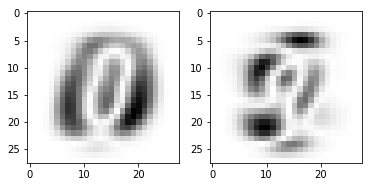

In [14]:
rows, columns = 1, 2
# Let's visualise the absolute values of each feature as a large negative is just as important as a large positive one.
np_abs = np.vectorize(abs)
for i in range(rows*columns):
    plt.subplot(rows, columns, i+1)
    f = plt.imshow(np_abs(pca.components_[i]).reshape(28,28), cmap='Greys')

Slightly different! Let's do PCA on the extended data, both the binarized one

Now lets find some more principal components. This time I will initialise PCA with a minimal desired value of explained variance ratio of 90%, meaning I keep 90% of the info in the original (binarized) data.

In [15]:
pca = PCA(n_components=.90)
digits_binarized_pca = pca.fit_transform(digits)

In [16]:
pca.n_components_

87

In [17]:
pca.n_components_ / (28*28)

0.11096938775510204

In [17]:
pca_binarized = PCA(n_components=.90)
digits_binarized_pca = pca_binarized.fit_transform(digits_binarized)

In [18]:
pca_binarized.n_components_

169

In [19]:
pca_binarized.n_components_ / (28*28)

0.21556122448979592

Wow, with the binarized data 169 features are needed to describe our 784 dimensional data while keeping 90% of the variance. 
However, with the raw data only 87 featyres are needed. Most likely the binarization enhances the importance of many pixels increasing the number of features required. As the binarization is tossing away information in an atempt to simplify our modeling, but results in almost twice as many required features, we will just use the raw data moving forward.

Now let's also do the PCA to the extended training set, shifted one pixel in every direction.

In [22]:
from scipy.ndimage.interpolation import shift
class DigitShifter(BaseEstimator, TransformerMixin):
    def __init__(self, directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]):
        self.directions = directions
    def fit(self, X, y = None):
        return self
    def transform(self, X, y= None):
        X_shifts = [np.apply_along_axis(lambda x: self.shift_digit(x, direction[0], direction[1]), 1, X) for direction in self.directions]
        return np.concatenate([X] + X_shifts)
    def shift_digit(self, digit, delta_x=0, delta_y=0):
        digit = digit.reshape(28, 28)
        return shift(digit, (delta_x, delta_y)).flatten()

In [23]:
digits_extended = DigitShifter().transform(digits)

In [24]:
labels_extended = np.concatenate([labels for i in range(len(digits_extended)//len(labels))])

In [23]:
pca = PCA(n_components=.90)
digits_pca = pca.fit_transform(digits_extended)

In [24]:
pca.n_components_

91

The extended data set requires just 91 features!

# Nearest Neighbours

Let's tune a nearest neighbours classifier using grid search. 

I want to try different values for K number of neighbours, different distance meassurement functions as well as dropping the feature binarization.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

First let's time classification of the whole data set using the same parameters I used last time around, just to compare prediction time.

In [26]:
knn = KNeighborsClassifier(algorithm="brute", n_neighbors=3)
knn.fit(digits_pca, labels_extended)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [19]:
test = pd.read_csv('test.csv').values

In [28]:
test_pca = pca.transform(test)
#pipeline.transform(test)

In [31]:
%%time
predictions = knn.predict(test_pca[:1000])
%time

Wall time: 0 ns
Wall time: 5.01 s


In [35]:
%%time
predictions = [knn.predict(test_pca[i*1000:(i+1)*1000]) for i in range(len(test) // 1000)]
%time

Wall time: 0 ns
Wall time: 2min 4s


About 3 times faster than last time, this will be much more enjoyable.

Might as well test accuracy to see what effect the 10% of variance we lost have.

In [36]:
predictions_flat = np.array(predictions).flatten()
submission_df = pd.DataFrame(list(zip(np.arange(1, 28001), predictions_flat)), columns = ['ImageID', 'Label'])
submission_df.set_index('ImageID').to_csv('Submissions/submission5.csv')

Accuracy was actually improved to 98.18%! Let's see what some parameter tuning can do!

To reduce prediction time, let's just use data from the base set.
However, let's still use the principal components of the extended set as those are what we will use for the finished model. Maybe this is bad practice, but it feels like an okay idea to me.

After some laboration it turns out GridSearch still grinds to a halt during the crossvalidation even with the reduced numbers of features. I will have to implement my own variant predicting smaller batches. Also, prediction time is still very high, so I will reduce the number of dimensions even further.

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from math import ceil

In [69]:
pca_80 = PCA(n_components=.80)
digits_pca = pca_80.fit_transform(digits_extended)

In [70]:
pca_80.n_components_

47

In [54]:
skfold = StratifiedKFold(n_splits=3, random_state = 0)

In [72]:
digits_pca = pca_80.transform(digits)

In [74]:
digits_pca[train].shape

(27996, 47)

In [75]:
df_test[i*1000:min((i+1)*1000, len(df_test))].shape

(1000, 47)

In [79]:
np.hstack(predictions).shape

(14004,)

In [78]:
df_test.shape

(14004, 47)

In [81]:
fold_res

[]

In [85]:
%%time
results = []
# Test some different values of n
for n in [3, 5, 7, 9]:
    print("n_neighbours = {}".format(n))
    fold_res = []
    i = 1
    # Test accuracy by crossfolding, using StratifiedKFold to keep same label distribution in all folds
    for train, test in skfold.split(digits_pca, labels):
        print("Fold {}".format(i))
        i += 1
        model = KNeighborsClassifier(n_neighbors=n)
        model.fit(digits_pca[train], labels[train])
        df_test = digits_pca[test]
        predictions = [model.predict(df_test[i*1000:min((i+1)*1000, len(df_test))]) for i in range(ceil(len(df_test) / 1000))]
        acc = accuracy_score(labels[test], np.hstack(predictions))
        fold_res.append(acc)
    print(fold_res)
    results.append(fold_res)

n_neighbours = 5
Fold 1
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.97086546700942589, 0.96963851978854121, 0.97092441777396776]
n_neighbours = 7
Fold 1
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.9706512425021423, 0.96892413201885985, 0.96992427489641375]
n_neighbours = 9
Fold 1
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.96936589545844043, 0.96785255036433782, 0.96863837691098731]
Wall time: 8min 14s


In [88]:
for n, acc in zip([3, 5, 7, 9], results):
    print(n, np.mean(acc))

3 0.971190359385
5 0.970476134857
7 0.969833216472
9 0.968618940911


Lets also try n=4.

In [89]:
fold_res = []
for train, test in skfold.split(digits_pca, labels):
    model = KNeighborsClassifier(n_neighbors=4)
    model.fit(digits_pca[train], labels[train])
    df_test = digits_pca[test]
    predictions = [model.predict(df_test[i*1000:min((i+1)*1000, len(df_test))]) for i in range(ceil(len(df_test) / 1000))]
    acc = accuracy_score(labels[test], np.hstack(predictions))
    fold_res.append(acc)

In [91]:
model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [90]:
print(4, np.mean(fold_res))

4 0.970166526013


Worse than both 3 and 5. Let's see what results we get with 3 neighbours and 80 % explained variance.

In [92]:
digits_pca = pca_80.transform(digits_extended)

In [100]:
knn = KNeighborsClassifier(algorithm="brute", n_neighbors=3)
knn.fit(digits_pca, labels_extended)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [95]:
test = pd.read_csv('test.csv').values

In [96]:
test_pca = pca_80.transform(test)
#pipeline.transform(test)

In [101]:
%%time
predictions = knn.predict(test_pca[:1000])
%time

Wall time: 0 ns
Wall time: 7.74 s


In [102]:
%%time
predictions = [knn.predict(test_pca[i*1000:(i+1)*1000]) for i in range(len(test) // 1000)]
%time

Wall time: 0 ns
Wall time: 3min 1s


In [103]:
predictions_flat = np.array(predictions).flatten()
submission_df = pd.DataFrame(list(zip(np.arange(1, 28001), predictions_flat)), columns = ['ImageID', 'Label'])
submission_df.set_index('ImageID').to_csv('Submissions/submission6.csv')

98.34% accuracy on Kaggle! It's probably worth it trying with even fewer principal components. I should do some more experimenting.

Actually, accuracy increasing with fewer dimensions might not be very surprising. A Nearest Neighbour model values all dimensions equally when calculting distances. By reducing the digits to fewer of the data sets principal components I effectively apply new weight to the pixels based on the variance the contribute to the data set. Let's try to reduce the number of dimensions even further.

In [20]:
pca_unbounded = PCA()

In [26]:
pca_unbounded.fit(digits_extended)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
pca_unbounded.explained_variance_ratio_.shape

(784,)

(1, 200)

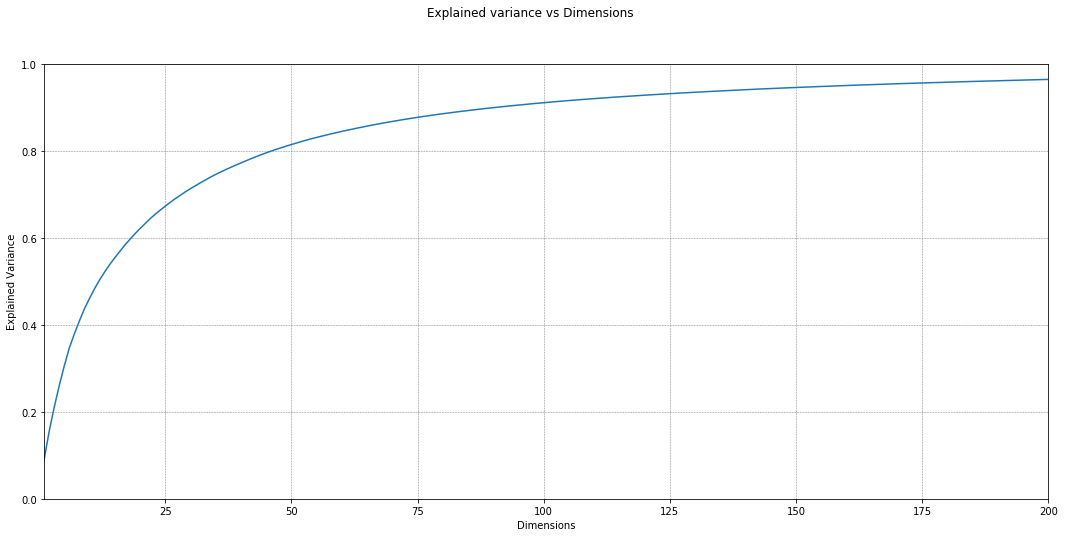

In [48]:
f, ax = plt.subplots(figsize= (18, 8))
plt.plot(np.arange(1, 201), np.cumsum(pca_unbounded.explained_variance_ratio_[:200]))
f.suptitle('Explained variance vs Dimensions')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Dimensions')
ax.grid(color='grey', linestyle='--', linewidth=.5)

ax.set_ylim([0, 1])
ax.set_xlim(1, 200)

(1, 25)

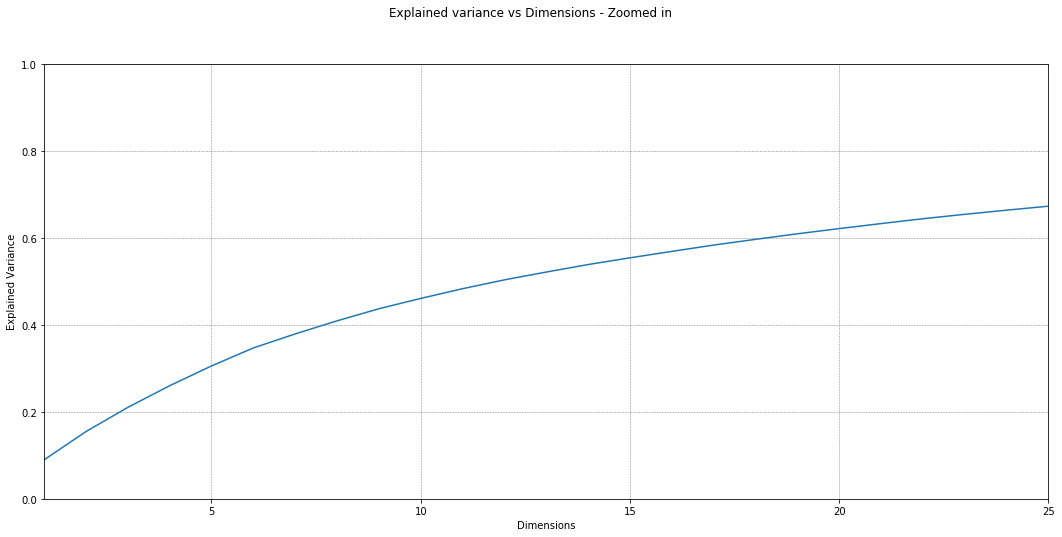

In [47]:
f, ax = plt.subplots(figsize= (18, 8))
plt.plot(np.arange(1, 26), np.cumsum(pca_unbounded.explained_variance_ratio_[:25]))
f.suptitle('Explained variance vs Dimensions - Zoomed in')
ax.set_ylabel('Explained Variance')
ax.set_xlabel('Dimensions')
ax.grid(color='grey', linestyle='--', linewidth=.5)
ax.set_ylim([0, 1])
ax.set_xlim(1, 25)

Lets try some of these low values: 5, 10, 15, 20 and 25!

In [56]:
results = []
# Test some different values of n
for dims in [5, 10, 15, 20, 25]:
    print("Dimensions = {}".format(dims))
    pca_dim = PCA(dims)
    digits_extended_pca = pca_dim.fit_transform(digits_extended)
    fold_res = []
    i = 1
    # Test accuracy by crossfolding, using StratifiedKFold to keep same label distribution in all folds
    for train, test in skfold.split(digits_extended_pca, labels_extended):
        print("Fold {}".format(i))
        i += 1
        model = KNeighborsClassifier(n_neighbors=3)
        model.fit(digits_extended_pca[train], labels_extended[train])
        df_test = digits_extended_pca[test]
        predictions = [model.predict(df_test[i*1000:min((i+1)*1000, len(df_test))]) for i in range(ceil(len(df_test) / 1000))]
        acc = accuracy_score(labels_extended[test], np.hstack(predictions))
        fold_res.append(acc)
    print(fold_res)
    results.append(fold_res)

Dimensions = 5
Wall time: 0 ns
Fold 1
Wall time: 0 ns
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.69156595525842124, 0.63803891317390937, 0.67388136464940851]
Dimensions = 10
Wall time: 0 ns
Fold 1
Wall time: 0 ns
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.9419016599525728, 0.91565955258421183, 0.92652437282130407]
Dimensions = 15
Wall time: 0 ns
Fold 1
Wall time: 0 ns
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.97414359589726007, 0.96525813548184336, 0.96341219498257047]
Dimensions = 20
Wall time: 0 ns
Fold 1
Wall time: 0 ns
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.98234336161823943, 0.97628639181737664, 0.97642722441282359]
Dimensions = 25
Wall time: 0 ns
Fold 1
Wall time: 0 ns
Wall time: 0 ns
Fold 2
Wall time: 0 ns
Wall time: 0 ns
Fold 3
Wall time: 0 ns
[0.9858575469272306, 0.98081483386188961, 0.98162752157266131]


In [57]:
for n, acc in zip([5, 10, 15, 20, 25], results):
    print(n, np.mean(acc))

5 0.667828744361
10 0.928028528453
15 0.967604642121
20 0.978352325949
25 0.982766634121


Wow, we get very good accuracy at 25 dimensions. Though this time I did crossvalidation on the extended set, while last time I did it on just the base set. Therefore, accuracy is not really comparable to what I saw last time. Anyway, let's try the test set.

In [62]:
pca = PCA(25)
digits_extended_pca =pca.fit_transform(digits_extended)

In [60]:
knn = KNeighborsClassifier(algorithm="brute", n_neighbors=3)
knn.fit(digits_extended_pca, labels_extended)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [64]:
test = pd.read_csv('test.csv')

In [65]:
test_pca = pca.transform(test)
#pipeline.transform(test)

In [66]:
%%time
predictions = knn.predict(test_pca[:1000])
%time

Wall time: 0 ns
Wall time: 4.51 s


In [67]:
%%time
predictions = [knn.predict(test_pca[i*1000:(i+1)*1000]) for i in range(len(test) // 1000)]
%time

Wall time: 0 ns
Wall time: 2min 32s


In [68]:
predictions_flat = np.array(predictions).flatten()
submission_df = pd.DataFrame(list(zip(np.arange(1, 28001), predictions_flat)), columns = ['ImageID', 'Label'])
submission_df.set_index('ImageID').to_csv('Submissions/submission7.csv')

98.0% accruacy, which is not an increase comapred to last time. But still quite remarkable that we get such good accuracy on just 25 dimensions. PCA is increadible!

I could probably increase accuracy by finding a better number of dimensions or including the test set when doing PCA.